**Dataset Features (18 CSV files):**

---

1. **dailyActivity_merged**: Aggregated daily activity data, including steps, distance, active minutes, and calories burned (940 rows).
2. **dailyCalories_merged**: Daily total calories burned for each individual (940 rows).
3. **dailyIntensities_merged**: Daily breakdown of activity intensities, including active minutes and distances categorized by intensity levels (940 rows).
4. **dailySteps_merged**: Total number of steps taken each day (940 rows).
5. **heartrate_seconds_merged**: Heart rate data collected at second-level intervals throughout the day (2483658 rows).
6. **hourlyCalories_merged**: Hourly calorie expenditure data for each individual (22099 rows).
7. **hourlyIntensities_merged**: Hourly activity intensity data, including total and average intensity for each hour (22099 rows).
8. **hourlySteps_merged**: Hourly step count data for each individual (22099 rows).
9. **minuteCaloriesNarrow_merged**: Minute-level calorie expenditure data using a narrow measurement method (1325580 rows).
10. **minuteCaloriesWide_merged**: Minute-level calorie expenditure data using a wide measurement method, with detailed hourly breakdowns (21645 rows).
11. **minuteIntensitiesNarrow_merged**: Minute-level activity intensity data using a narrow measurement method (1325580 rows).
12. **minuteIntensitiesWide_merged**: Minute-level activity intensity data using a wide measurement method, with detailed breakdowns by minute for each hour. (21645 rows)
13. **minuteMETsNarrow_merged**: Minute-level METs (Metabolic Equivalent of Task) data using a narrow measurement method (1325580 rows).
14. **minuteSleep_merged**: Minute-level sleep data, including sleep patterns and duration (188521 rows).
15. **minuteStepsNarrow_merged**: Minute-level step count data using a narrow measurement method. (1325580 rows)
16. **minuteStepsWide_merged**: Minute-level step count data using a wide measurement method. (21645 rows)
17. **sleepDay_merged**: Sleep records, including the date, total sleep records, total minutes asleep, and total time spent in bed for each day (413 rows).
18. **WeightLogInfo_merged**: Weight log information with the date, weight in kilograms and pounds, body fat percentage, BMI, whether the report is manual, and a unique log ID (67 rows).

---

Removed the following files: `dailyCalories_merged.csv`, `dailyIntensities_merged.csv`, `dailySteps_merged.csv`, `minuteCaloriesNarrow_merged.csv`, `minuteCaloriesWide_merged.csv`, `minuteMETsNarrow_merged.csv`, `weightLogInfo_merged.csv` and `minuteStepsNarrow_merged.csv`.

#**1. Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import sys
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from dateutil import parser

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report,
                             ConfusionMatrixDisplay, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, balanced_accuracy_score)
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import (ExtraTreesClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_sample_weight

from mlxtend.plotting import plot_confusion_matrix
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

warnings.filterwarnings('ignore')

import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import six
sys.modules['sklearn.externals.six'] = six

#**2. Preprocessing**

Converting the heartrate in seconds form to minutes by taking mean.

In [ ]:
input_file = r'..Arrhythmia\Data\Seconds\heartrate_seconds_merged.csv'
output_file = r'..Arrhythmia\Data\Minutes\minuteHeartrate.csv'

df = pd.read_csv(input_file)

def parse_timestamp(timestamp):
    try:
        return parser.parse(timestamp)
    except parser.ParserError:
        return pd.NaT

df['Time'] = df['Time'].apply(parse_timestamp)
df = df.dropna(subset=['Time'])

result = df.groupby(['Id', pd.Grouper(key='Time', freq='1Min')])['Value'].mean().reset_index()
result['Value'] = result['Value'].round().astype(int)
result.to_csv(output_file, index=False)

Merging the `minuteheartrate.csv` and `minuteSleep.csv`

In [ ]:
heart_rate_df = pd.read_csv(r'..Arrhythmia\Data\Minutes\minuteheartrate.csv')
minute_sleep_df = pd.read_csv(r'..Arrhythmia\Data\Minutes\minuteSleep.csv')

# Standardizing the date format in the 'Time' column using dateutil.parser
heart_rate_df['Time'] = heart_rate_df['Time'].apply(lambda x: parse(x))
minute_sleep_df['Time'] = minute_sleep_df['Time'].apply(lambda x: parse(x))

heart_rate_df['Sleep'] = 0

# Iterate through the heart rate DataFrame and check for matching 'Id' and 'Time' in the minute sleep DataFrame
for index, row in heart_rate_df.iterrows():
    match_condition = (minute_sleep_df['Id'] == row['Id']) & (minute_sleep_df['Time'] == row['Time'])
    if match_condition.any():
        heart_rate_df.at[index, 'Sleep'] = 1

Creating feature **Abheartrate** based on the **Heart rate** column

In [ ]:
# Create a new feature "Abheartrate" with default value 1
heart_rate_df['Abheartrate'] = 1

# Define the conditions and update the "Abheartrate" feature 
# Condition 1: Heart rate between 60 and 100 and sleep is 0
condition1 = (heart_rate_df['Value'] >= 60) & (heart_rate_df['Value'] <= 100) & (heart_rate_df['Sleep'] == 0)

# Condition 2: Heart rate between 40 and 50 and sleep is 1
condition2 = (heart_rate_df['Value'] >= 40) & (heart_rate_df['Value'] <= 50) & (heart_rate_df['Sleep'] == 1)

# Set the "Abheartrate" column to 0 where either condition 1 or condition 2
heart_rate_df.loc[condition1 | condition2, 'Abheartrate'] = 0

Changing intensities wide to narrow.

In [ ]:
# Read the original dataset from the CSV file
df = pd.read_csv(r"..Arrhythmia\Intensities\minuteIntensitiesWide_merged.csv")

# Initialize an empty list to store the transformed data
transformed_data = []

# Iterate through the rows of the filtered dataset
for _, row in df.iterrows():
    id_value = row['Id']
    activity_hour = parse(row['ActivityHour'], fuzzy=True)
    
    for minute in range(60):
        minute_str = f'Intensity{minute:02d}'
        intensity_value = row[minute_str]
        
        # Create a new timestamp for each minute
        minute_timestamp = activity_hour + pd.Timedelta(minutes=minute)
        
        # Append a row for each minute with the corresponding "ActivityHour" and "Intensity"
        if intensity_value != 0:  # Only include rows with non-zero intensity
            transformed_data.append([id_value, minute_timestamp, intensity_value])

# Create a new DataFrame with the transformed data
transformed_df = pd.DataFrame(transformed_data, columns=['Id', 'Time', 'Intensity'])

Merging `intensities` with `heart_rate_df`

In [ ]:
# Read the first dataset
df1 = transformed_df

# Read the second dataset
df2 = heart_rate_df

# Merge the datasets based on both "Id" and "Time"
merged_df = pd.merge(df2, df1, on=["Id", "Time"], how="left")

# Reorder columns to place "Intensity" before "Abheartrate"
merged_df = merged_df[["Id", "Time", "Value", "Sleep", "Intensity", "Abheartrate"]]

# Fill blanks in the "Intensity" column with zero
merged_df["Intensity"].fillna(0, inplace=True)

# Make anything greater than zero in the "Intensity" column as 1
merged_df["Intensity"] = (merged_df["Intensity"] > 0).astype(int)

# Set "Abheartrate" values to 0 where "Intensity" is 1
merged_df.loc[merged_df["Intensity"] == 1, "Abheartrate"] = 0

# Rename columns
merged_df = merged_df.rename(columns={'Value': 'Bpm', 'Abheartrate': 'Arrhythmia'})

# Save the merged dataset to a new CSV file
merged_df.to_csv(r"..Arrhythmia\Data\heartrate_final.csv", index=False)

#**3. EDA - Exploratory Data Analysis**

###**3.1 General**

In [89]:
data = pd.read_csv(r"C:\Users\Ibrahim\Desktop\Arrhythmia\Data\heartrate_final.csv") 

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333420 entries, 0 to 333419
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Id          333420 non-null  int64 
 1   Time        333420 non-null  object
 2   Bpm         333420 non-null  int64 
 3   Sleep       333420 non-null  int64 
 4   Intensity   333420 non-null  int64 
 5   Arrhythmia  333420 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 15.3+ MB


In [37]:
#Check if there are NA values.
data.isnull().sum().any()

False

In [38]:
#Check if there are duplicate values.
data = data.drop_duplicates()
data.duplicated().sum()

0

Now, there is no missing/duplicate data.

In [39]:
data.head()

,Id,Time,Bpm,Sleep,Intensity,Arrhythmia
0,2022484408,2016-04-12 07:21:00,102,0,0,1
1,2022484408,2016-04-12 07:22:00,88,0,0,0
2,2022484408,2016-04-12 07:23:00,58,0,0,1
3,2022484408,2016-04-12 07:24:00,58,0,0,1
4,2022484408,2016-04-12 07:25:00,57,0,0,1


In [40]:
data = data.drop(['Id', 'Time'], axis=1)

In [41]:
data.describe()

,Bpm,Sleep,Intensity,Arrhythmia
count,333420.000000,333420.000000,333420.000000,333420.000000
mean,73.711022,0.166247,0.259586,0.256670
std,16.561728,0.372303,0.438408,0.436797
min,37.000000,0.000000,0.000000,0.000000
25%,62.000000,0.000000,0.000000,0.000000
50%,70.000000,0.000000,0.000000,0.000000
75%,83.000000,0.000000,1.000000,1.000000
max,202.000000,1.000000,1.000000,1.000000


In [42]:
data_vis = data.copy()

In [43]:
unique_values = {}
for col in data_vis.columns:
    unique_values[col] = data_vis[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()
data_vis

,Bpm,Sleep,Intensity,Arrhythmia
0,102,0,0,1
1,88,0,0,0
2,58,0,0,1
3,58,0,0,1
4,57,0,0,1
...,...,...,...,...
333415,56,0,0,1
333416,58,0,0,1
333417,56,0,0,1
333418,58,0,0,1


###**3.2 Frequency of the value of the features in the dataset.**

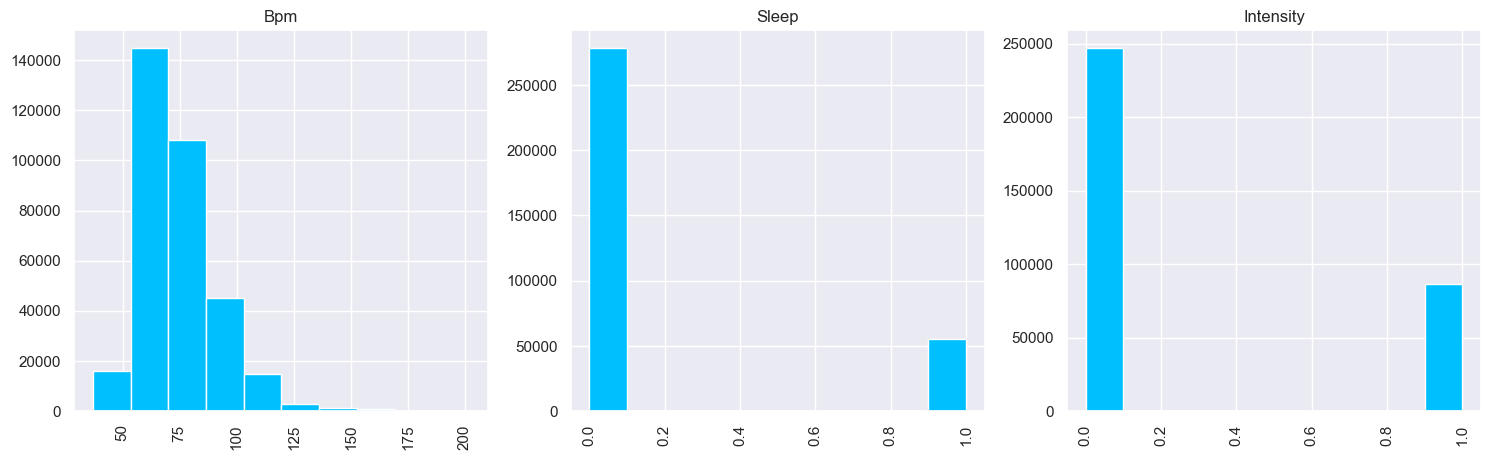

In [44]:
# All data columns except for color
feature_cols = [x for x in data_vis.columns if x not in 'Arrhythmia']
plt.figure(figsize=(25,35))
# loop for subplots
for i in range(len(feature_cols)):
    plt.subplot(8,5,i+1)
    plt.title(feature_cols[i])
    plt.xticks(rotation=90)
    plt.hist(data_vis[feature_cols[i]],color = "deepskyblue")
    
plt.tight_layout()

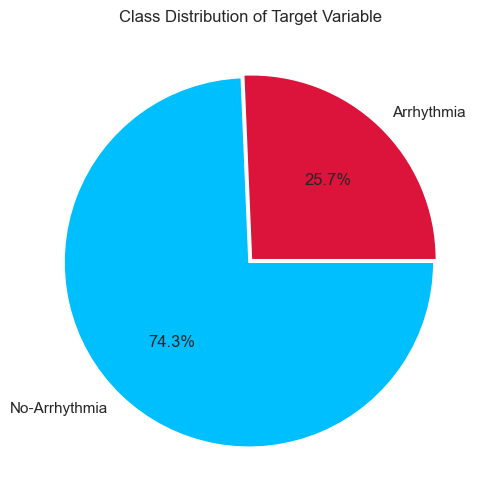

In [45]:
# Traget values frequency
plt.figure(figsize=(8,6))
labels = ['Arrhythmia', 'No-Arrhythmia']
sizes = [data_vis['Arrhythmia'].value_counts()[1],data_vis['Arrhythmia'].value_counts()[0]]
colors = ['crimson', 'deepskyblue']
explode = (0.01,0.01)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, autopct='%.1f%%', colors=colors, data = data_vis);
plt.title('Class Distribution of Target Variable')
plt.show()

The prediction column classes are imbalanced.

###**3.3 Correlation between each feature and Arrhythmia**

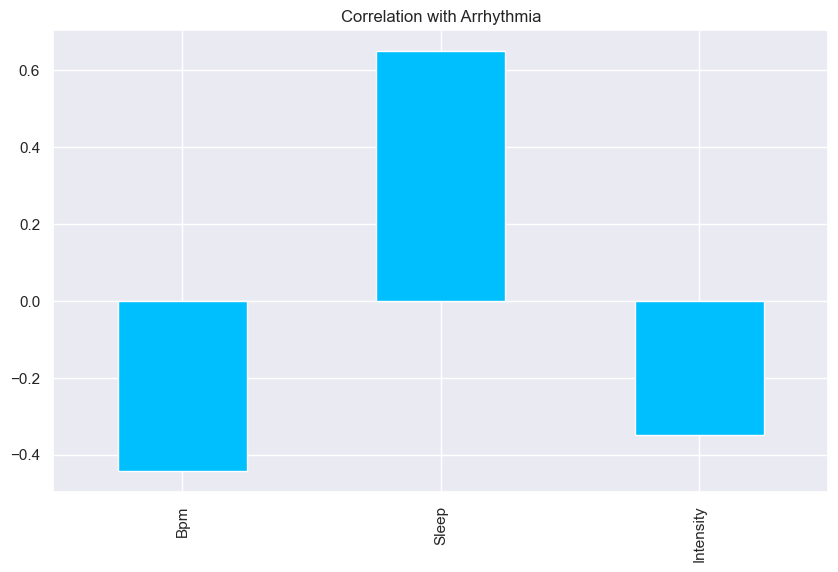

In [46]:
data.drop('Arrhythmia', axis=1).corrwith(data.Arrhythmia).plot(kind='bar', grid=True, figsize=(10, 6), title="Correlation with Arrhythmia",color="deepskyblue");

The features "Bpm" and "", "Intensity" are negatively correlated while sleep is positively correlated with Arrhythmia.

###**3.4 Correlation between any two features**

<Axes: >

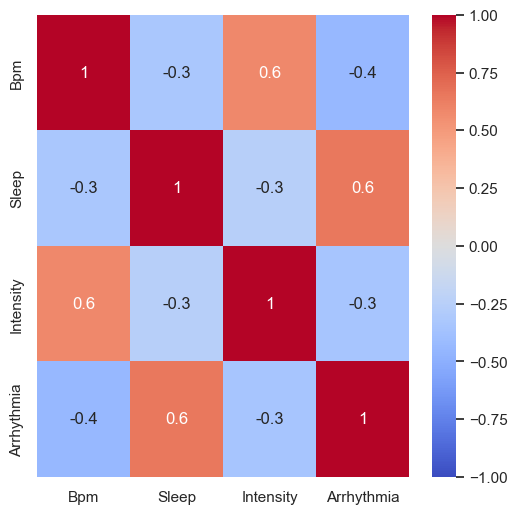

In [47]:
sns.set(rc = {'figure.figsize':(6,6)})
sns.heatmap(data.corr(),vmin=-1, vmax=1, annot = True, fmt='.1g',cmap= 'coolwarm')

###**3.5 Arrhythmia frequency by numeric features**

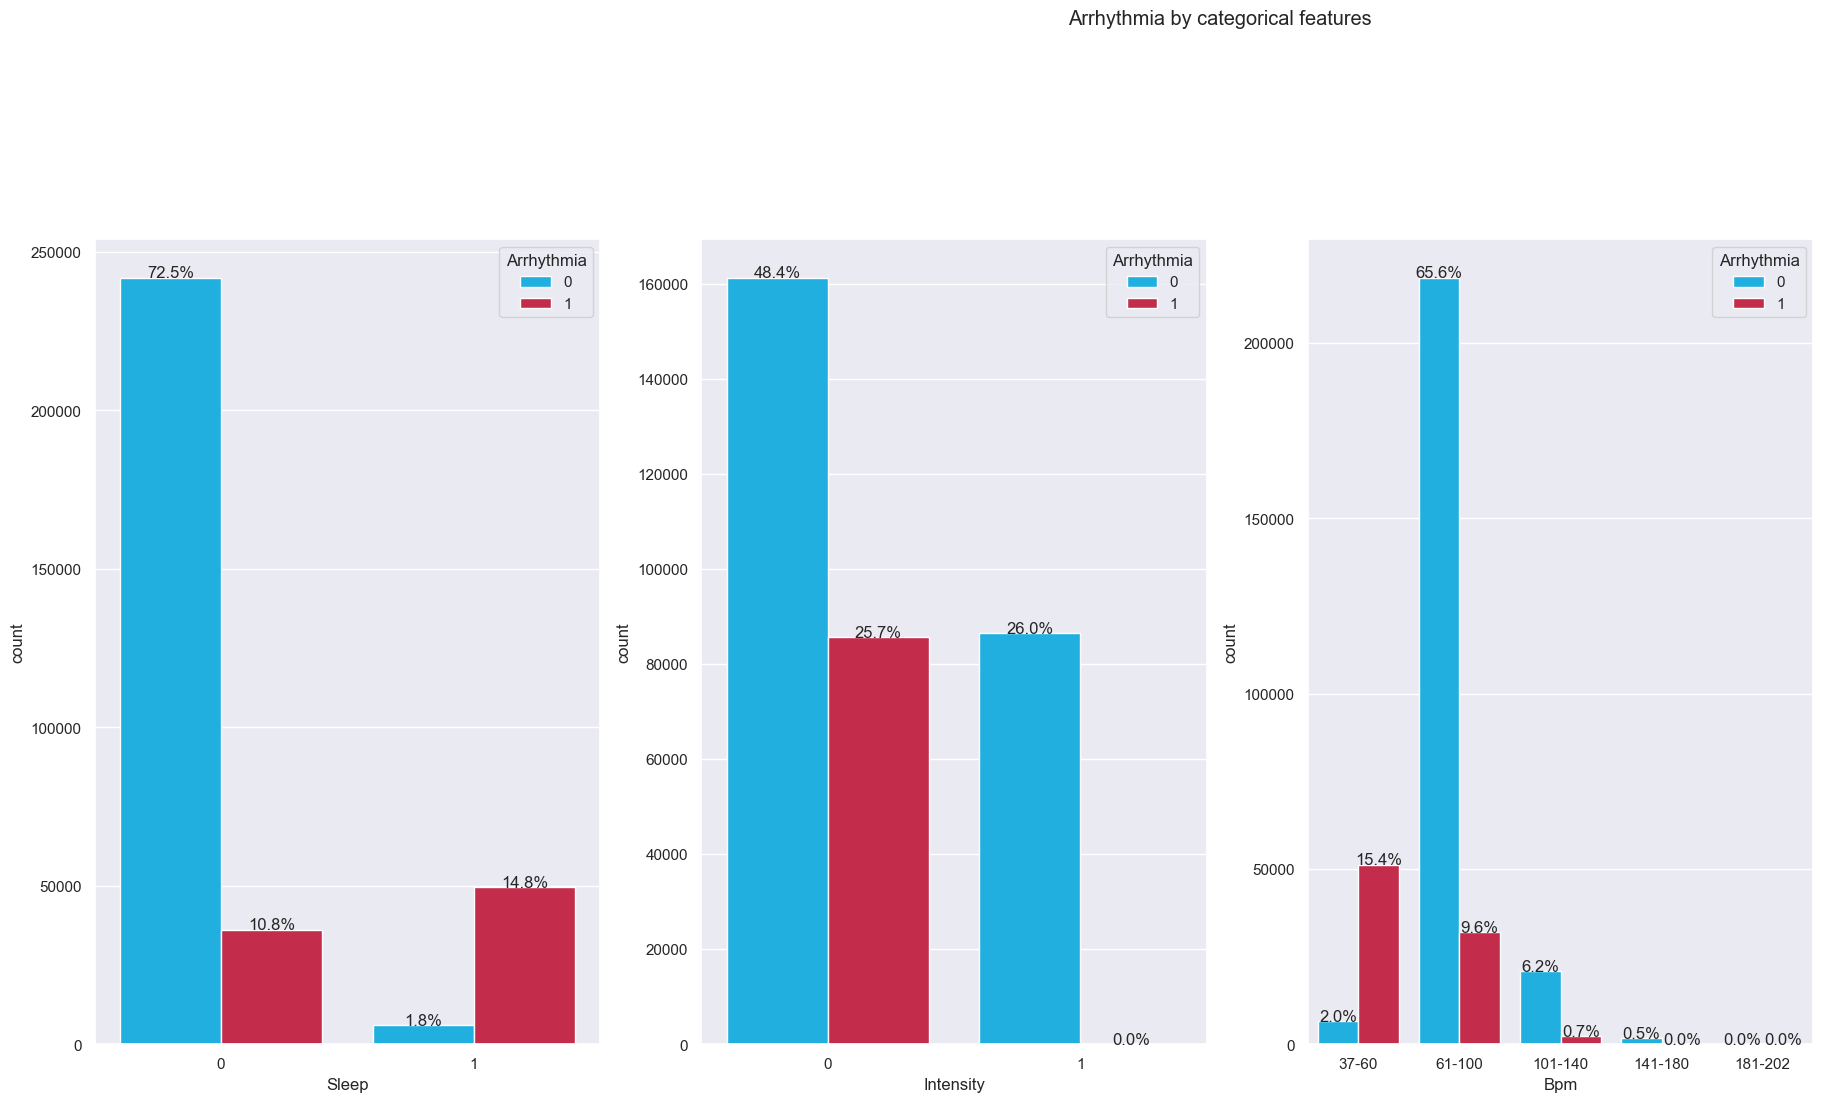

In [48]:
# Define the bin edges based on the bpm range (37 to 202)
bins = [37, 60, 100, 140, 180, 202]  # You can adjust these ranges as needed
labels = ['37-60', '61-100', '101-140', '141-180', '181-202']  # Labels for the bins

# Bin the 'Bpm' values directly into the 'BPM' column
data_vis['BPM'] = pd.cut(data_vis['Bpm'], bins=bins, labels=labels, right=False)

# Features to plot (excluding 'Bpm', 'Arrhythmia', and 'BPM' from the list)
features = [x for x in data_vis.columns if x != 'Bpm' and x != 'Arrhythmia']  # Exclude 'Bpm' and 'Arrhythmia'

# Plotting the countplots
plt.figure(figsize=(30,23))
plt.suptitle('Arrhythmia by categorical features')

# Subplots
for index, feature in enumerate(features):
    plt.subplot(2, 4, index + 1)
    if feature == 'BPM':  # Use the binned bpm in the 'BPM' column for plotting
        ax = sns.countplot(x='BPM', hue='Arrhythmia', data=data_vis, palette=['deepskyblue', 'crimson'])
        plt.xlabel('Bpm')
    else:
        ax = sns.countplot(x=feature, hue='Arrhythmia', data=data_vis, palette=['deepskyblue', 'crimson'])
        plt.xlabel(feature)

    # Annotating the percentages
    total_count = len(data_vis)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.01, '{:.1f}%'.format((height / total_count) * 100),
                ha="center")

# Show the plot
plt.show()

# Drop the temporary 'temp_binned' column after plotting
data_vis.drop('Bpm', axis=1, inplace=True)

###**3.6 The effect of combining categorical features on Arrhythmia**

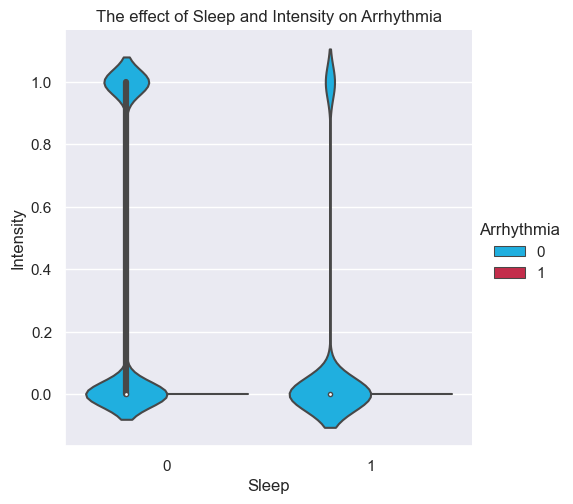

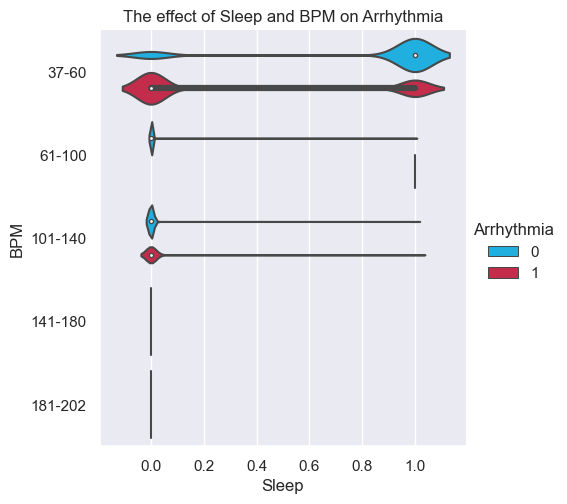

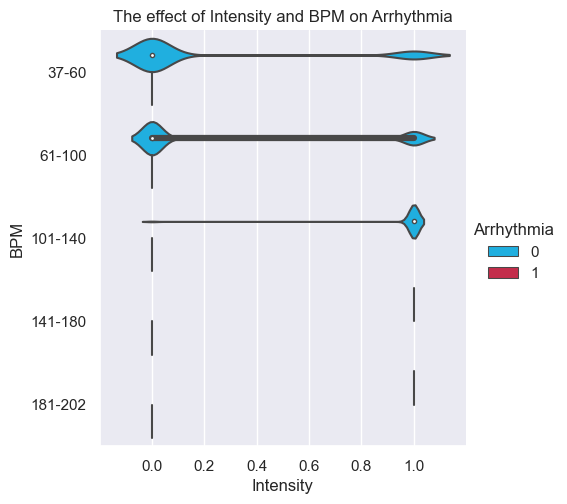

In [53]:
# Loop to create plots
for i in range(len(features)):
    for x in range(len(features) - i - 1):
        sns.catplot(
            data=data_vis, 
            x=features[i], 
            y=features[i + x + 1], 
            hue="Arrhythmia", 
            kind="violin", 
            palette=['deepskyblue', 'crimson']
        ).set(title="The effect of " + features[i] + " and " + features[i + x + 1] + " on Arrhythmia")

###**3.7 Numeric features distributions**

**Bmi**

<Figure size 1200x500 with 0 Axes>

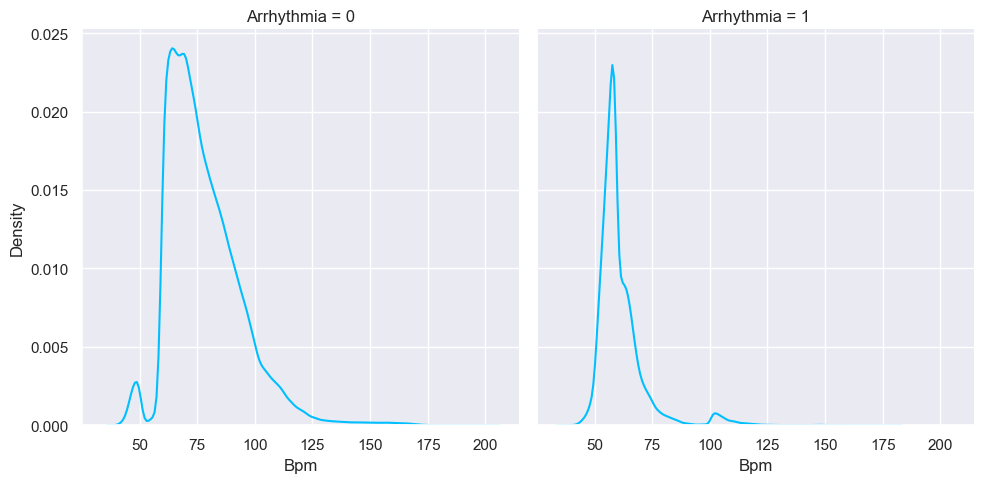

In [57]:
plt.figure(figsize=(12,5))
sns.displot(x='Bpm', col='Arrhythmia' , data = data, kind="kde" ,color = 'deepskyblue');

Using binned data to see the distribution clearly

<Figure size 1200x2000 with 0 Axes>

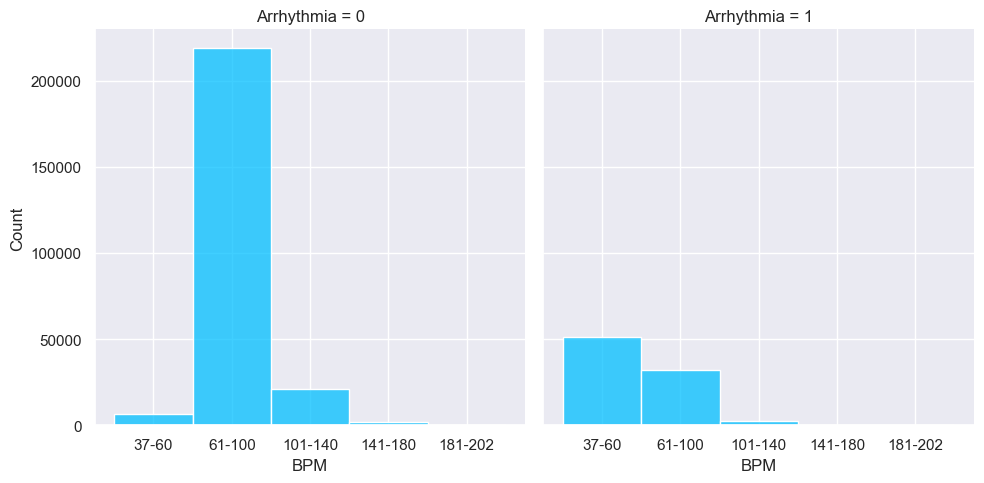

In [59]:
plt.figure(figsize=(12,20))
sns.displot(data=data_vis,col='Arrhythmia',x='BPM',color='deepskyblue');

The median, range and values in the "avg_glucose_level" feature is higher when there is a stroke / hypertension / heart_disease.

#**4. Data Preparation**

###**4.1 Data Splitting**

In [37]:
data = pd.read_csv(r"C:\Users\Ibrahim\Desktop\Arrhythmia\Data\heartrate_final.csv") 

In [3]:
X = data[["Bpm", "Sleep", "Intensity"]]
y = data["Arrhythmia"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Arrhythmia
0    0.743432
1    0.256568
Name: proportion, dtype: float64
Arrhythmia
0    0.742922
1    0.257078
Name: proportion, dtype: float64


In [39]:
X_train

,Bpm,Sleep,Intensity
27135,87,0,1
226013,82,1,0
172291,95,0,1
65960,47,1,0
116765,86,0,0
...,...,...,...
119879,57,1,0
259178,88,0,0
131932,68,0,0
146867,68,1,0


#**4. ML - Models**

###**4.1 Logistic Regression**

In [5]:
#function that get y_test and calculate into df all the relevant metric
def train_evaluate_model(y_test):
    #fit the model instance 
    predictions = y_pred_test # calculate predictions

    #compute metrics for evaluation
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions)

    #create a dataframe to visualize the results
    eval_df = pd.DataFrame([[accuracy, f1, precision, recall, balanced_accuracy, auc]], columns=['accuracy', 'f1_score', 'precision', 'recall', 'balanced_accuracy', 'auc'])
    return eval_df

Building a simple logistic regression model.

In [6]:
LG = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
#prediction
y_pred_test = LG.predict(X_test)
y_pred_train = LG.predict(X_train)

Overfitting checking:

In [7]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9338409513526483
0.9357866954591806


No Overfitting. Model Results are excellent.

**The model predicts Arrhythmia with a high accuracy of 93.5%.**

The model metrics:

In [8]:
results = train_evaluate_model(y_test)
results.index = ['Logistic Regression']
results.style.background_gradient(cmap = sns.color_palette("blend:green,red", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.935787,0.886141,0.814219,0.972000,0.947628,0.947628


Confusion Matrix

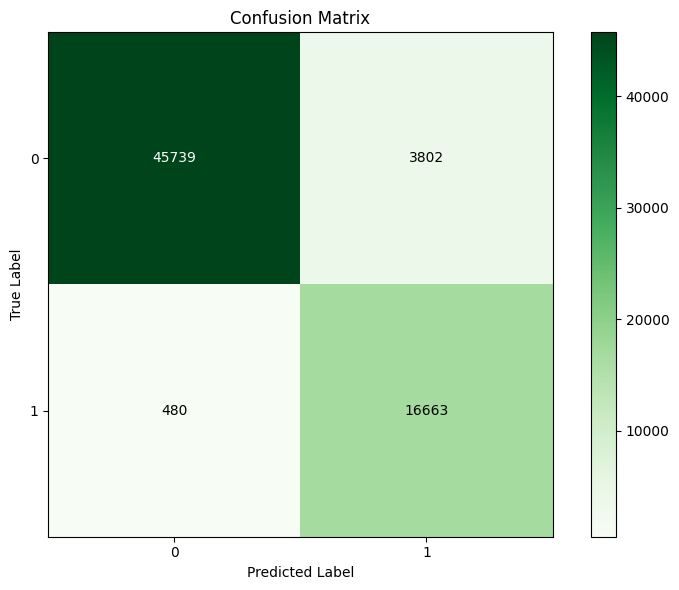

In [9]:
# Get the best estimator from the grid search
best_estimator = LG

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

###**4.2 Support Vector Machine**

Search for the best model parameters with GridSearchCV.

In [10]:
SVM = SVC(kernel='rbf', class_weight='balanced', C=1.0, gamma='scale')
SVM.fit(X_train, y_train)
y_pred_test = SVM.predict(X_test)
y_pred_train = SVM.predict(X_train)

Overfitting checking:

In [11]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9556677763781417
0.9570061783936177


There is low overfitting, but the model results are good.

**The model predicts strokes with a high accuracy of 86%.**

Model metrics:

In [12]:
resultsSVM = train_evaluate_model(y_test)
resultsSVM.index = ['Support Vector Machine']
results = pd.concat([results, resultsSVM])

In [13]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.935787,0.886141,0.814219,0.972000,0.947628,0.947628
Support Vector Machine,0.957006,0.922014,0.863812,0.988625,0.967345,0.967345


Confusion Matrix

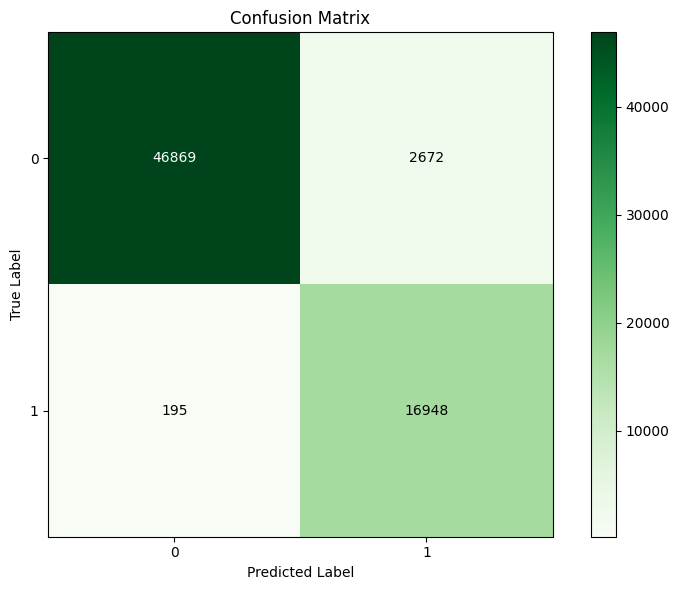

In [14]:
# Get the best estimator from the grid search
best_estimator = SVM

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

###**4.3 Decision Tree**

In [15]:
DT = DecisionTreeClassifier(random_state=42, class_weight='balanced' )
DT.fit(X_train, y_train)
y_pred_test = DT.predict(X_test)
y_pred_train = DT.predict(X_train)

Building a model with restrictions - Search for the best model parameters with GridSearchCV.

In [17]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

# defining parameter range
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1),
              'class_weight' : ['balanced']}  
gridDT = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, n_jobs=-1)
  
# fitting the model for grid search
gridDT.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': range(1, 5, 2),
                         'max_features': range(1, 4)})

Get the best parameters.

In [18]:
print(gridDT.best_params_)

{'class_weight': 'balanced', 'max_depth': 3, 'max_features': 2}


Prediction according to this model.

In [19]:
y_pred_test = gridDT.predict(X_test)
y_pred_train = gridDT.predict(X_train)

Overfitting Checking:

In [20]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9926706556295363
0.9929368364225302


There is low overfitting, the model results are excellent.

**The model predicts strokes with a high accuracy of 99.2%.**

Model metrics:

In [21]:
resultsDT = train_evaluate_model(y_test)
resultsDT.index = ['Decision Trees']
results = pd.concat([results, resultsDT])

In [22]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.935787,0.886141,0.814219,0.972000,0.947628,0.947628
Support Vector Machine,0.957006,0.922014,0.863812,0.988625,0.967345,0.967345
Decision Trees,0.992937,0.986071,1.000000,0.972525,0.986263,0.986263


Confusion Matrix

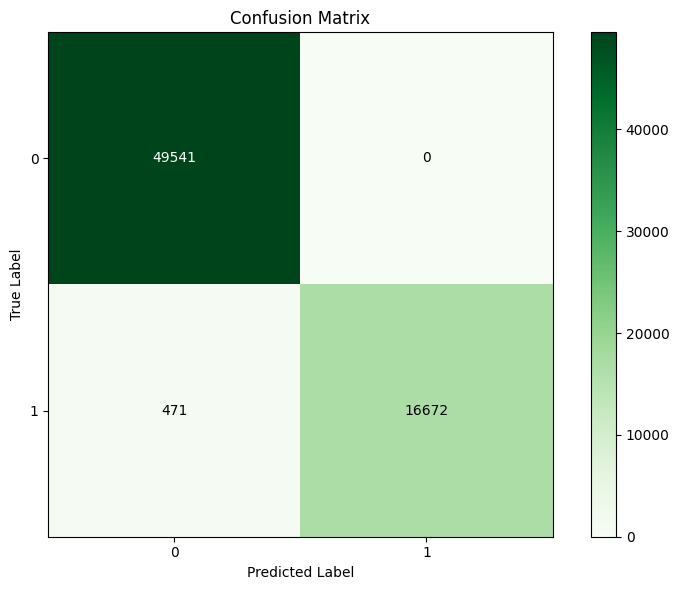

In [23]:
best_estimator = gridDT.best_estimator_

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

###**4.4 Random Forest**

Search for the best model parameters with GridSearchCV.

In [24]:
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

# defining parameter range
param_grid = {'n_estimators':[15, 20, 30, 40, 50, 100],
              'class_weight' : ['balanced']
              }  
gridRF = GridSearchCV(RF, param_grid)
  
# fitting the model for grid search
gridRF.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42,
                                              warm_start=True),
             param_grid={'class_weight': ['balanced'],
                         'n_estimators': [15, 20, 30, 40, 50, 100]})

Get the best parameters.

In [25]:
print(gridRF.best_params_)

{'class_weight': 'balanced', 'n_estimators': 15}


In [33]:
# Check for duplicates
print(set(X_train.index).intersection(X_test.index))

set()


,Bpm,Sleep,Intensity
27135,87,0,1
226013,82,1,0
172291,95,0,1
65960,47,1,0
116765,86,0,0
...,...,...,...
119879,57,1,0
259178,88,0,0
131932,68,0,0
146867,68,1,0


Prediction according to this model.

In [26]:
y_pred_test = gridRF.predict(X_test)
y_pred_train = gridRF.predict(X_train)

Overfitting Checking:

In [27]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

1.0
1.0


There is low overfitting, the model results are excellent.

**The model predicts strokes with a high accuracy of 99.2%.**

**The most important metric - RECALL - is good. less stroke patient will be missed.**

Model metrics:

In [28]:
resultsRF = train_evaluate_model(y_test)
resultsRF.index = ['Random Forest']
results = pd.concat([results, resultsRF])
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.935787,0.886141,0.814219,0.972000,0.947628,0.947628
Support Vector Machine,0.957006,0.922014,0.863812,0.988625,0.967345,0.967345
Decision Trees,0.992937,0.986071,1.000000,0.972525,0.986263,0.986263
Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Confusion Matrix

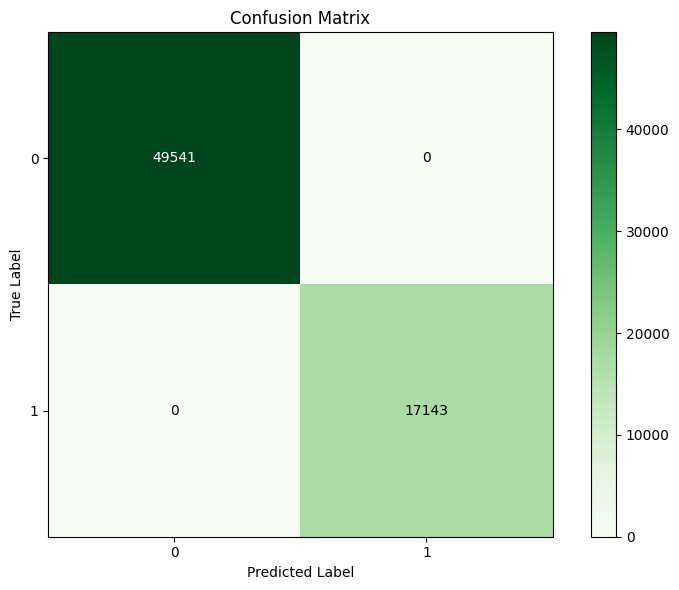

In [29]:
# Get the best estimator from the grid search
best_estimator = gridRF.best_estimator_

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#**5. Summary**

###**5.1 Conclusions & Suggestions For Improvement**

In [31]:
#order the result df by accuracy from high to low.
results.sort_values(results.columns[0], ascending = False)

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Decision Trees,0.992937,0.986071,1.000000,0.972525,0.986263,0.986263
Support Vector Machine,0.957006,0.922014,0.863812,0.988625,0.967345,0.967345
Logistic Regression,0.935787,0.886141,0.814219,0.972000,0.947628,0.947628


* The algorithms based on decision trees yield impressive results.

**Test the models with new data can help validate the models.**

**Exporting Random forest because its the best Model**

In [46]:
import pickle
# Open a file in binary write mode and save the model
with open(r'C:\Users\Ibrahim\Desktop\Webpage\model\A_RF.pickle', 'wb') as file:
    pickle.dump(gridRF, file)